In [17]:
import torch
import numpy as np
# Define the path to the saved .pt file
#dolensek_file_path = r"C:\Users\avs20\Documents\GitHub\facemap\data\dolensek_test_224_new.pt"
#facemap_file_path = r"C:\Users\avs20\Documents\GitHub\facemap\data\facemap_224.pt"

# Load the data from the .pt file
#data_dolensek = torch.load(dolensek_file_path)
#data_facemap = torch.load(facemap_file_path)


# Extract images, labels, and filenames from the loaded data
#x_d = data_dolensek['images']  # Tensor of images
#y_d = data_dolensek['labels']  # Tensor of keypoints (shape: N x 2*K)


#x_f = data_facemap['images']  # Tensor of images
#y_f = data_facemap['labels']  # Tensor of keypoints (shape: N x 2*K)

x_d, y_d = torch.load("data/dolensek_test_224_new.pt")
x_f, y_f = torch.load("data/facemap_224.pt")

#print(y_d.shape)

#y_d = y_d.numpy()  # Convert `y` to numpy if needed
#y_f = y_f.numpy()


# Convert images and labels to PyTorch tensors if they are NumPy arrays
#if isinstance(x_d, np.ndarray):
#    x_d = torch.from_numpy(x_d)
#if isinstance(y_d, np.ndarray):
#    y_d = torch.from_numpy(y_d)

#if isinstance(x_f, np.ndarray):
#    x_f = torch.from_numpy(x_f)
#if isinstance(y_f, np.ndarray):
#    y_f = torch.from_numpy(y_f)

# Ensure tensors are of the same data type (e.g., float32 for images)
#x_d = x_d.float()
#x_f = x_f.float()
#y_d = y_d.float()
#y_f = y_f.float()

# Combine images and labels
x_combined = torch.cat((x_d, x_f), dim=0)  # Concatenate images along the first dimension
#y_combined = torch.cat((y_d, y_f), dim=0)  # Concatenate labels along the first dimension

# Concatenate images and labels as NumPy arrays
#x_combined = np.concatenate((x_d, x_f), axis=0)
y_combined = np.concatenate((y_d, y_f), axis=0)

# Save the combined dataset
final_save_path = "data/dolensek_facemap_224.pt"
torch.save((x_combined, y_combined), final_save_path)

print(f"Combined dataset saved to {final_save_path}")


Combined dataset saved to data/dolensek_facemap_224.pt


In [18]:
import torch

# Load the combined dataset
final_save_path = "data/dolensek_facemap_224.pt"
x_combined, y_combined = torch.load(final_save_path)

# Print the shapes of the loaded tensors
print(f"Shape of combined images tensor: {x_combined.shape}")
print(f"Shape of combined labels tensor: {y_combined.shape}")


Shape of combined images tensor: torch.Size([287, 1, 224, 224])
Shape of combined labels tensor: (287, 24)


In [21]:

# make soft labels

import pdb
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
from skimage import io

# Load data
x, y = torch.load("data/dolensek_facemap_224.pt")
h, w = x[0].shape[1], x[1].shape[2]  # Image height and width
print(x.shape)

# Set the sigma for Gaussian filter
sigma = 3  # Increase from original 3 to 5

# Initialize the tensor for soft labels
softlabels = torch.zeros(x.shape)

# Loop through each set of keypoints and generate soft labels
for i in range(len(y)):
    mask = np.zeros((h, w))  # Initialize an empty mask of zeros
    
    # Get the keypoints, remove NaNs and separate x, y coordinates
    y_i = y[i][~np.isnan(y[i])]
    idx_x, idx_y = y_i[1::2].astype(int), y_i[::2].astype(int)
    
    # Ensure indices are within bounds (0 to 223 for a 224x224 image)
    idx_x = np.clip(idx_x, 0, h - 1)  # Clamp x indices to be between 0 and h-1
    idx_y = np.clip(idx_y, 0, w - 1)  # Clamp y indices to be between 0 and w-1

    # Mark the valid keypoints in the mask
    mask[idx_x, idx_y] = 1
    
    # Apply Gaussian filter to the mask to generate soft labels
    label = gaussian_filter(mask, sigma=sigma)
    
    # Store the soft labels in the tensor
    softlabels[i, 0] = torch.Tensor(label)

# Save the data including soft labels
torch.save((x, y, softlabels), "data/dolensek_facemap_softlabels_224.pt")

# Print the shape of the tensor (for debugging purposes)
print(softlabels.shape)


torch.Size([287, 1, 224, 224])
torch.Size([287, 1, 224, 224])


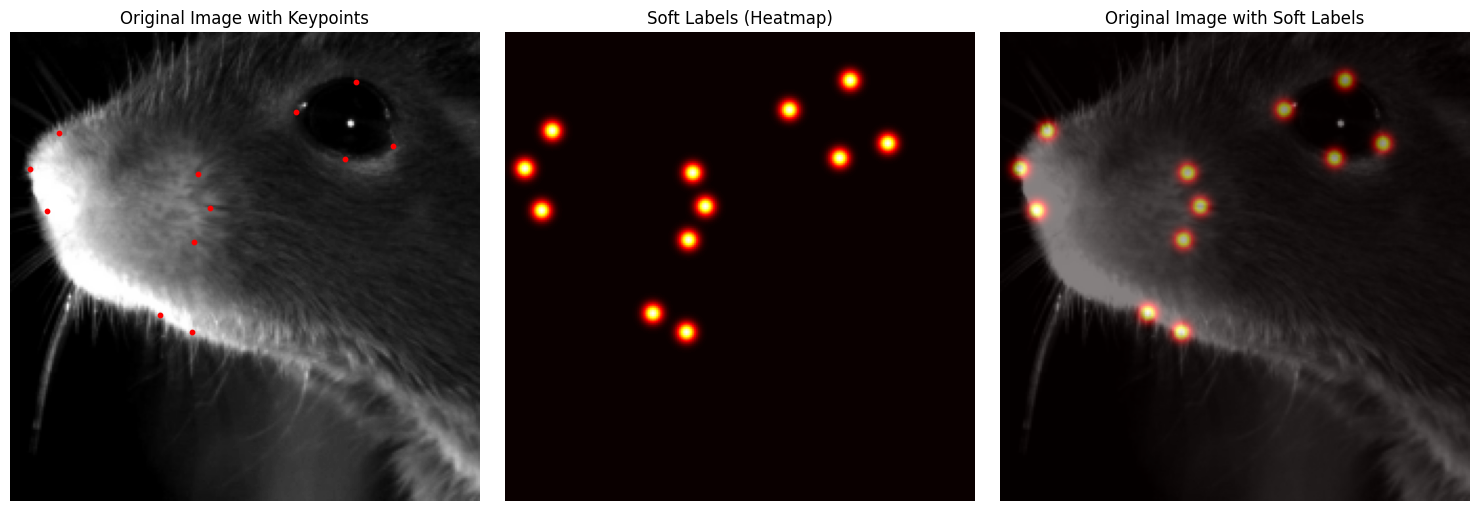

In [5]:
import matplotlib.pyplot as plt
import torch
import numpy as np
# Load the data
x, y, softlabels = torch.load("data/dolensek_facemap_softlabels_224.pt")

# Select a sample index to visualize
sample_idx = 200  # Change this to visualize different samples
image = x[sample_idx, 0].numpy()  # Extract the image (assuming grayscale channel 0)
softlabel = softlabels[sample_idx, 0].numpy()  # Extract the soft label
keypoints = y[sample_idx][~np.isnan(y[sample_idx])]  # Extract keypoints without NaNs
keypoints_x = keypoints[::2]
keypoints_y = keypoints[1::2]

# Plot the original image, keypoints, and soft label
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.scatter(keypoints_x, keypoints_y, color="red", s=10)  # Overlay keypoints
plt.title("Original Image with Keypoints")
plt.axis("off")

# Soft label (heatmap)
plt.subplot(1, 3, 2)
plt.imshow(softlabel, cmap="hot")
plt.title("Soft Labels (Heatmap)")
plt.axis("off")

# Overlay soft labels on original image
plt.subplot(1, 3, 3)
plt.imshow(image, cmap="gray")
plt.imshow(softlabel, cmap="hot", alpha=0.5)  # Use alpha for transparency
plt.title("Original Image with Soft Labels")
plt.axis("off")

plt.tight_layout()
plt.show()
